## CMSC 35300 Final Project

In [73]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

In [2]:
df = read_csv('ml-25m/ratings.csv')
df = df.drop('timestamp', axis=1)
df.loc[:,'rating'] *= 2  # make the ratings into an integer value
df = df.astype(int)

max_userId = df.max().loc['userId']
max_movieId = df.max().loc['movieId']
observation_number = df.index[-1]+1

observed_data = df.to_numpy()
observed_data[:,:-1] = observed_data[:,:-1] -1

In [64]:
def power_factorization(n, X0, Y0, t_set, k, lambd, N):
    slices = observation_number//N
    
    X = X0
    Y = Y0
    X1 = np.zeros((k,max_userId))
    Y1 = np.zeros((k,max_movieId))
    
    startTime = time.time()

    iteration = 0
    # print('Current inner-iteration: ' + str(iteration))
    # print('np.linalg.norm(X1-X) = ' + str(np.linalg.norm(X1-X)))
    # print('np.linalg.norm(Y1-Y) = ' + str(np.linalg.norm(Y1-Y))+'\n')

    Xnorm_diff = np.linalg.norm(X1-X)
    Ynorm_diff = np.linalg.norm(Y1-Y)

    while True:
        iteration += 1
        # print('Current inner-iteration: ' + str(iteration))


        u_to_sums = {}
        for s in range(slices):
            u, i, r = t_set[s,:]
            if u not in u_to_sums.keys():
                u_to_sums[u] = {'sum_yi_yiT':np.zeros((k,k)), 'sum_rui_yi':np.zeros((k,1))}
            u_to_sums[u]['sum_yi_yiT'] += Y[:,i:i+1]@Y[:,i:i+1].T
            u_to_sums[u]['sum_rui_yi'] += r*Y[:,i:i+1]
        for u in u_to_sums.keys():
            X1[:,u:u+1] = np.linalg.inv(u_to_sums[u]['sum_yi_yiT']+lambd*np.diag(np.ones(k)))@u_to_sums[u]['sum_rui_yi']

        executionTime = (time.time() - startTime)
        # print('Elapsed time in seconds: ' + str(executionTime))

        Xnorm_diff = np.linalg.norm(X1-X)
        # print('np.linalg.norm(X1-X) = ' + str(Xnorm_diff)+'\n')

        if Xnorm_diff<1e-5 and Ynorm_diff<1e-5:
            break

        X = X1


        i_to_sums = {}
        for s in range(slices):
            u, i, r = t_set[s,:]
            if i not in i_to_sums.keys():
                i_to_sums[i] = {'sum_xu_xuT': np.zeros((k,k)), 'sum_rui_xu': np.zeros((k,1))}
            i_to_sums[i]['sum_xu_xuT'] += X[:,u:u+1]@X[:,u:u+1].T
            i_to_sums[i]['sum_rui_xu'] += r*X[:,u:u+1]
        for i in i_to_sums.keys():
            Y1[:,i:i+1] = np.linalg.inv(i_to_sums[i]['sum_xu_xuT']+lambd*np.diag(np.ones(k)))@i_to_sums[i]['sum_rui_xu']

        executionTime = (time.time() - startTime)
        # print('Elapsed time in seconds: ' + str(executionTime))

        Ynorm_diff = np.linalg.norm(Y1-Y)
        # print('np.linalg.norm(Y1-Y) = ' + str(Ynorm_diff)+'\n')

        if Xnorm_diff<1e-5 and Ynorm_diff<1e-5:
            break

        Y = Y1


    executionTime = (time.time() - startTime)
    # print('Execution time in seconds: ' + str(executionTime))
    # print('Total inner-iterations: ' + str(iteration))
    
    return X, Y

In [65]:
def create_split_sets(N):
    startTime = time.time()
    
    slices = observation_number//N

    split_sets = np.zeros((N,slices, 3), dtype=int)

    random_indices = np.arange(observation_number)
    np.random.shuffle(random_indices)
    random_indices = random_indices.reshape((N,slices))

    for i in range(N):
        for j in range(slices):
            split_sets[i,j,:] = observed_data[random_indices[i,j],:]
    
    executionTime = (time.time() - startTime)
    # print('Execution time in seconds: ' + str(executionTime))
    
    return split_sets

In [66]:
def calculate_average_RMS(split_sets, k, lambd, N):
    startTime = time.time()

    slices = observation_number//N
    X0 = np.random.uniform(0,10,(k, max_userId))
    Y0 = np.random.uniform(0,10,(k, max_movieId))

    average_RMS = 0
    for n in range(N):
        training_set = np.zeros(((N-1)*slices,3), dtype=int)
        test_set = np.zeros((slices,3), dtype=int)
        temp = np.append(split_sets[:n,:,:], split_sets[n+1:,:,:],axis=0)
        for t in range(N-1):
            training_set[t*slices:(t+1)*slices,:] = temp[t:t+1,:,:]
        test_set[:,:] = split_sets[n:n+1,:,:]

        X, Y = power_factorization(n, X0, Y0, training_set, k, lambd, N)

        sum_first_term = 0
        for s in range(slices):
            u, m, r = test_set[s,:]
            sum_first_term += (r - X[:,u].T@Y[:,m])**2

        # print("For n=" + str(n) + ": sum_first_term + lambda*Frobenius_norm = " + str(sum_first_term + lambd*(np.linalg.norm(X)+np.linalg.norm(Y))))
        # print("RMS for n=" + str(n) + ": " + str(np.sqrt(sum_first_term/slices)))
        average_RMS += np.sqrt(sum_first_term/slices)
    average_RMS /= N
    print("Average RMS for k=" + str(k) + ", lambda=" + str(lambd) +": " + str(average_RMS))

    executionTime = (time.time() - startTime)
    print('Execution time in seconds: ' + str(executionTime) + "\n")
    
    return average_RMS, executionTime


In [68]:
N = 5

kwargs_list = []
for k in [5, 10, 15, 20, 25, 30]:
    for lambd in [10, 100, 1000, 10000, 100000, 1000000]:
        kwargs_list.append({'N': N, 'k': k, 'lambd': lambd})

split_sets = create_split_sets(N)

In [69]:
new_kwargs_list = []
for kwargs in kwargs_list:
    average_RMS, executionTime = calculate_average_RMS(split_sets, **kwargs)
    kwargs['average_RMS'] = average_RMS
    kwargs['executionTime'] = executionTime
    new_kwargs_list.append(kwargs)

Average RMS for k=5, lambda=10: 2.088103338466175
Execution time in seconds: 1364.422256231308

Average RMS for k=5, lambda=100: 2.7196876619144894
Execution time in seconds: 1274.9718589782715

Average RMS for k=5, lambda=1000: 4.882878612254315
Execution time in seconds: 1238.1388669013977

Average RMS for k=5, lambda=10000: 7.378019703981335
Execution time in seconds: 1245.5381557941437

Average RMS for k=5, lambda=100000: 7.379242498731503
Execution time in seconds: 1240.8431339263916

Average RMS for k=5, lambda=1000000: 7.379242499192398
Execution time in seconds: 1239.5704717636108

Average RMS for k=10, lambda=10: 2.261053177256763
Execution time in seconds: 1298.1460421085358

Average RMS for k=10, lambda=100: 2.946800500589621
Execution time in seconds: 1298.156325340271

Average RMS for k=10, lambda=1000: 4.9425406511523695
Execution time in seconds: 1293.7090198993683

Average RMS for k=10, lambda=10000: 7.378069271736663
Execution time in seconds: 1307.3968591690063

Avera

In [74]:
new_kwargs_list

[{'N': 5,
  'k': 5,
  'lambd': 10,
  'average_RMS': 2.088103338466175,
  'executionTime': 1364.422256231308},
 {'N': 5,
  'k': 5,
  'lambd': 100,
  'average_RMS': 2.7196876619144894,
  'executionTime': 1274.9718589782715},
 {'N': 5,
  'k': 5,
  'lambd': 1000,
  'average_RMS': 4.882878612254315,
  'executionTime': 1238.1388669013977},
 {'N': 5,
  'k': 5,
  'lambd': 10000,
  'average_RMS': 7.378019703981335,
  'executionTime': 1245.5381557941437},
 {'N': 5,
  'k': 5,
  'lambd': 100000,
  'average_RMS': 7.379242498731503,
  'executionTime': 1240.8431339263916},
 {'N': 5,
  'k': 5,
  'lambd': 1000000,
  'average_RMS': 7.379242499192398,
  'executionTime': 1239.5704717636108},
 {'N': 5,
  'k': 10,
  'lambd': 10,
  'average_RMS': 2.261053177256763,
  'executionTime': 1298.1460421085358},
 {'N': 5,
  'k': 10,
  'lambd': 100,
  'average_RMS': 2.946800500589621,
  'executionTime': 1298.156325340271},
 {'N': 5,
  'k': 10,
  'lambd': 1000,
  'average_RMS': 4.9425406511523695,
  'executionTime': 1

In [71]:
# Write to a JSON file
with open("iterations.json", "w") as outfile:
    json.dump(new_kwargs_list, outfile)

In [72]:
# Opening JSON file
with open('iterations.json', 'r') as openfile:
    # Reading from json file
    json_object = json.load(openfile)

for dic in json_object:
    print(dic)

{'N': 5, 'k': 5, 'lambd': 10, 'average_RMS': 2.088103338466175, 'executionTime': 1364.422256231308}
{'N': 5, 'k': 5, 'lambd': 100, 'average_RMS': 2.7196876619144894, 'executionTime': 1274.9718589782715}
{'N': 5, 'k': 5, 'lambd': 1000, 'average_RMS': 4.882878612254315, 'executionTime': 1238.1388669013977}
{'N': 5, 'k': 5, 'lambd': 10000, 'average_RMS': 7.378019703981335, 'executionTime': 1245.5381557941437}
{'N': 5, 'k': 5, 'lambd': 100000, 'average_RMS': 7.379242498731503, 'executionTime': 1240.8431339263916}
{'N': 5, 'k': 5, 'lambd': 1000000, 'average_RMS': 7.379242499192398, 'executionTime': 1239.5704717636108}
{'N': 5, 'k': 10, 'lambd': 10, 'average_RMS': 2.261053177256763, 'executionTime': 1298.1460421085358}
{'N': 5, 'k': 10, 'lambd': 100, 'average_RMS': 2.946800500589621, 'executionTime': 1298.156325340271}
{'N': 5, 'k': 10, 'lambd': 1000, 'average_RMS': 4.9425406511523695, 'executionTime': 1293.7090198993683}
{'N': 5, 'k': 10, 'lambd': 10000, 'average_RMS': 7.378069271736663, 'e

In [117]:
k_list = [kwargs['k'] for kwargs in new_kwargs_list if kwargs['lambd'] == 100]
RMS_list = [kwargs['average_RMS'] for kwargs in new_kwargs_list if kwargs['lambd'] == 100]
execT_list = [kwargs['executionTime'] for kwargs in new_kwargs_list if kwargs['lambd'] == 100]

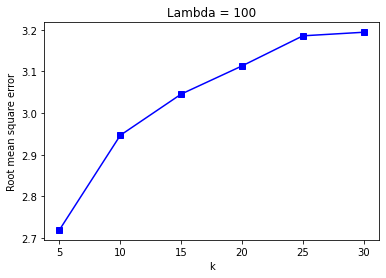

In [118]:
plt.plot(k_list, RMS_list, '-bs')
plt.xlabel('k') 
plt.ylabel('Root mean square error')
plt.title('Lambda = 100')
plt.savefig('k_RMSE.pdf', bbox_inches='tight')
plt.show()

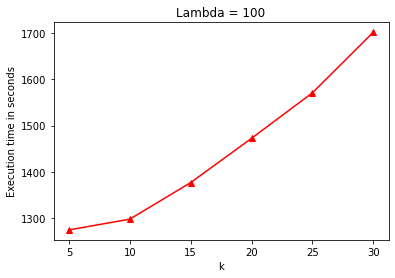

In [119]:
plt.plot(k_list, execT_list, '-r^')
plt.xlabel('k') 
plt.ylabel('Execution time in seconds')
plt.title('Lambda = 100')
plt.savefig('k_ExecT.pdf', bbox_inches='tight')
plt.show()

In [140]:
lambd_list = [kwargs['lambd'] for kwargs in new_kwargs_list if kwargs['k'] == 25]
RMS_list_lambd = [kwargs['average_RMS'] for kwargs in new_kwargs_list if kwargs['k'] == 25]
execT_list_lambd = [kwargs['executionTime'] for kwargs in new_kwargs_list if kwargs['k'] == 25]

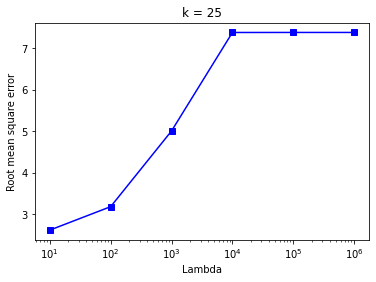

In [143]:
plt.plot(lambd_list, RMS_list_lambd, '-bs')
plt.xscale('log')
plt.xlabel('Lambda') 
plt.ylabel('Root mean square error')
plt.title('k = 25')
plt.savefig('lambd_RMSE.pdf', bbox_inches='tight')
plt.show()

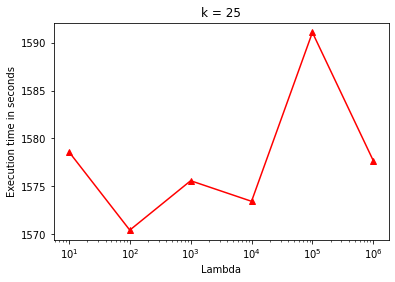

In [144]:
plt.plot(lambd_list, execT_list_lambd, '-r^')
plt.xscale('log')
plt.xlabel('Lambda') 
plt.ylabel('Execution time in seconds')
plt.title('k = 25')
plt.savefig('lambd_ExecT.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# np.savetxt('X.csv', X, delimiter=',')
# np.savetxt('Y.csv', Y, delimiter=',')

In [ ]:
# X = np.loadtxt('X.csv', delimiter=',')
# Y = np.loadtxt('Y.csv', delimiter=',')